In [1]:
import os
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from Levenshtein import distance as levenshtein_distance

import numpy as np
import cv2
# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import pandas as pd
from itertools import islice
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torchvision.io import read_image
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor,v2

import tensorflow as tf

from Train import Train

2024-11-27 18:00:58.003368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-27 18:00:58.019048: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-27 18:00:58.024092: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 18:00:58.036805: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-27 18:00:58.720605: W tensorflow/compiler/tf2

### **0 move and extract data**

### **1 Preparing data for Train OCR model**

 1.1 Load DataFrame

In [2]:
df = pd.read_csv("train_df.csv")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head(10)

,index,label,page,top_left_y,bot_right_y,top_left_x,bot_right_x,path
0,86244,درکنار,4468,590,620,45,96,04468_153_86244.png
1,275410,4335,4335,17,34,539,585,04335_0_275410.png
2,1234560,وتولد,5065,365,395,525,569,05065_71_1234560.png
3,782347,تراژدی‌ای,459,170,200,45,119,00459_42_782347.png
4,166182,افزود:استفاده,2664,435,465,192,285,02664_92_166182.png
5,77933,ریزگردها,2250,400,430,391,458,02250_87_77933.png
6,498681,سالگذشته,6715,330,360,507,573,06715_66_498681.png
7,186468,هولناک,5562,170,200,274,323,05562_35_186468.png
8,9457,اباالحسن,6711,135,165,282,342,06711_29_9457.png
9,899678,مواردرا,2937,135,165,341,398,02937_30_899678.png


1.2 Convert image path as key and it's label as value of dictionary.

In [3]:
dataset = df.set_index('path')['label'].to_dict()
dict(list(dataset.items())[0:10])

{'04468_153_86244.png': 'درکنار',
 '04335_0_275410.png': '4335',
 '05065_71_1234560.png': 'وتولد',
 '00459_42_782347.png': 'تراژدی\u200cای',
 '02664_92_166182.png': 'افزود:استفاده',
 '02250_87_77933.png': 'ریزگردها',
 '06715_66_498681.png': 'سالگذشته',
 '05562_35_186468.png': 'هولناک',
 '06711_29_9457.png': 'اباالحسن',
 '02937_30_899678.png': 'مواردرا'}

In [4]:
def find_longest_string(string_list):
  longest_string = ""
  for string in string_list:
    if len(string) > len(longest_string):
      longest_string = string
  return longest_string

In [5]:
def unique_chars_in_strings(string_list):
  """
  Finds the unique characters across a list of strings.

  Args:
    string_list: A list of strings.

  Returns:
    A set containing the unique characters found in the input strings.
  """
  unique_chars = set()
  for string in string_list:
    unique_chars.update(string)
  return unique_chars

# Example usage (assuming 'df' is your DataFrame and 'label' is the column name):
# unique_characters = unique_chars_in_strings(df['label'].tolist())
# print(unique_characters)

In [6]:
unique_characters = unique_chars_in_strings(df['label'].tolist())
print(unique_characters)
print(len(unique_characters))

{'ب', '(', 'ض', '.', 'ی', '6', '%', 'چ', 'ت', 'ذ', 'ح', 'خ', '»', '*', '5', 'پ', 'س', '4', '“', '3', 'ؤ', 'ن', '!', ')', 'ج', '/', 'و', 'د', 'ظ', '؟', '؛', 'ع', 'گ', 'ئ', 'ث', '7', '0', 'آ', '1', '8', 'ر', 'ط', '+', 'ق', 'أ', 'ک', 'م', 'غ', '9', '”', 'ً', 'ز', 'ل', ':', 'ش', 'ه', '«', 'ۀ', '2', '،', 'ص', 'ا', 'ف', '\u200c', 'ژ'}
65


In [7]:
# Assuming 'df' is your DataFrame and 'label' is the column containing the strings
rows_with_specific_char = df[df['label'].str.contains('أ', na=False)]
# pd.set_option('display.max_rows', df.shape[0]+1)
rows_with_specific_char

,index,label,page,top_left_y,bot_right_y,top_left_x,bot_right_x,path
748,403787,علأ,5919,660,690,297,321,05919_212_403787.png
1422,23362,نشأت,1714,645,675,203,241,01714_165_23362.png
1925,1271277,تأکیدی,1000,450,480,263,318,01000_104_1271277.png
2315,1225904,بی‌شکمتأثر,5076,450,480,299,375,05076_123_1225904.png
3194,5551,تأسیسات,702,240,270,445,507,00702_50_5551.png
...,...,...,...,...,...,...,...,...
51535,36610,هیأت,918,240,270,363,402,00918_60_36610.png
52642,930031,أضلالهم،,1296,575,605,461,522,01296_168_930031.png
53126,103190,مسأله,5248,380,410,396,431,05248_109_103190.png
53646,63631,مأموران,5533,715,745,172,229,05533_195_63631.png


In [8]:
t = find_longest_string(df['label'].tolist())
print(t,len(t))

یکشنبه20مهر1399برگزار 21


In [9]:
char_to_index = {
    '!': 1, '%': 2, '(': 3, ')': 4, '*': 5, '+': 6,
    '/': 7, '0': 8, '1': 9, '2': 10, '3': 11, '4': 12,
    '5': 13, '6': 14, '7': 15, '8': 16, '9': 17, ':': 18,
    '؛': 19, '؟': 20, 'آ': 21, 'أ': 22, 'ؤ': 23, 'ئ': 24,
    'ا': 25, 'ب': 26, 'پ': 27, 'ت': 28, 'ث': 29, 'ج': 30,
    'چ': 31, 'ح': 32, 'خ': 33, 'د': 34, 'ذ': 35, 'ر': 36,
    'ز': 37, 'ژ': 38, 'س': 39, 'ش': 40, 'ص': 41, 'ض': 42,
    'ط': 43, 'ظ': 44, 'ع': 45, 'غ': 46, 'ف': 47, 'ق': 48,
    'ک': 49, 'گ': 50, 'ل': 51, 'م': 52, 'ن': 53, 'ه': 54,
    'و': 55, 'ی': 56, 'ً': 57, '،': 58, '“': 59, '”': 60,
    '«': 61, '»': 62, '\u200c': 63, '.': 64, 'ۀ': 65
}
char_list =['!', '%', '(', ')', '*', '+', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '؛', '؟', 'آ', 'أ', 'ؤ', 'ئ', 'ا', 'ب', 'پ', 'ت', 'ث', 'ج', 'چ', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'ژ', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ک', 'گ', 'ل', 'م', 'ن', 'ه', 'و', 'ی', 'ً', '،', '“', '”', '«', '»', '\u200c', '.', 'ۀ']

1.3 Custom Torch dataclass

In [11]:
class OCRDataset(Dataset):
    def __init__(self, image_dir, labels, char_to_index, input_length, transform=None):
        """
        Args:
            image_dir (string): Path to the directory with images.
            labels (dict): A dictionary mapping image filenames to labels (e.g., text annotations).
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_dir = image_dir
        self.labels = labels
        self.transform = transform
        self.image_files = list(self.labels.keys())
        self.char_to_index = char_to_index
        self.input_length = input_length

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_name).convert("RGB")  # Load image
        label = self.labels[self.image_files[idx]]  # Load corresponding label (text)

        target_indices = [self.char_to_index[char] for char in label]

        # Get target length
        target_length = len(target_indices)

        # Convert to tensor if required by your model
        target_indices = torch.tensor(target_indices, dtype=torch.long)
        input_length = torch.tensor(self.input_length, dtype=torch.long)
        target_length = torch.tensor(target_length, dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, target_indices, input_length ,target_length

1.4 Apply Data Augmentation and Preprocessing

In [12]:
train_transforms = v2.Compose([
    v2.Grayscale(),
    v2.Resize((32, 100)),              # Resize all images to 128x128
    # v2.RandoRotation(10),             # Random rotation within 10 degrees
    # v2.RandmomPerspective(distortion_scale=0.3, p=1.0),
    # v2.ColorJitter(brightness=0.5),     # Random brightness adjustments
    # v2.RandomAffine(translate=(0.1, 0.1)),  # Random translation
    v2.ToTensor(),                      # Convert PIL image to a PyTorch Tensor
    v2.Normalize((0.0,), (0.1,))        # Normalize (mean, std) for grayscale images
])

val_transforms = v2.Compose([
    v2.Grayscale(),
    v2.Resize((32, 40)),
    v2.ToTensor(),
    v2.Normalize((0.0,), (0.1,))
])

/home/dornika/OCR_Project/OCR_env/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


1.5 Split data to Train, test and validation with proportion of 80%, 10% and 10% respectively.

In [13]:
img_dir = "persian_unique_ocr_dataset"

In [14]:
dataset = OCRDataset(img_dir, dataset, char_to_index , input_length=24,transform=train_transforms)
total_size = len(dataset)

# Define split sizes (e.g., 80% training, 10% validation, 10% testing)
train_size = int(0.8 * total_size)
# val_size = int(0.1 * total_size)
val_size = total_size - train_size  # Ensures no data leakage

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [15]:
def collate_fn(batch):
  """Custom collate function to handle variable-length sequences.

  Args:
      batch: A list of data samples, where each sample is a tuple
             of (image, label, length).

  Returns:
      A tuple containing:
          images: A batched tensor of images.
          labels: A padded tensor of labels.
          target_lengths: A tensor of label lengths.
  """
  images, labels, input_lengths, taget_lengths = zip(*batch)

  # Pad the labels to the maximum length in the batch
  labels = pad_sequence(labels, batch_first=True, padding_value=0)

  # Stack the images and lengths
  images = torch.stack(images, 0)
  input_lengths = torch.tensor(input_lengths)
  taget_lengths = torch.tensor(taget_lengths)

  return images, labels, input_lengths, taget_lengths

In [16]:
train_data = DataLoader(train_dataset, batch_size=200, shuffle=True,  collate_fn=collate_fn)
# test_data = DataLoader(test_dataset, batch_size=200, shuffle=True,  collate_fn=collate_fn)
val_data = DataLoader(val_dataset, batch_size=200, shuffle=True,  collate_fn=collate_fn)

### **2 OCR model architecture**

In [17]:
class CRNN(nn.Module):
    def __init__(self, imgH=32, num_channels=1, num_classes=66, hidden_units=256):
        super(CRNN, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(num_channels, 64, kernel_size=3, stride=1, padding=1),  # Conv1: #maps: 64, k:3 × 3, s:1, p:1
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),  # MaxPool: Window:2 × 2, s:2

            # Second Conv Block (Conv2)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Conv2: #maps: 128, k:3 × 3, s:1, p:1
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),  # MaxPool: Window:2 × 2, s:2

            # Third Conv Block (Conv3, Conv4)
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Conv3: #maps: 256, k:3 × 3, s:1, p:1
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # Conv4: #maps: 256, k:3 × 3, s:1, p:1
            nn.MaxPool2d(kernel_size=(2,1), stride=(2,1)),  # MaxPool: Window:2 × 2, s:2

            # Fourth Conv Block (Conv5)
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # Conv5: #maps: 512, k:3 × 3, s:1, p:1
            # nn.MaxPool2d(kernel_size=(1, 2), stride=(2)),
            nn.BatchNorm2d(512),
            # Fifth Conv Block (Conv6)
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),  # Conv6: #maps: 512, k:3 × 3, s:1, p:1
            nn.BatchNorm2d(512),
            # nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),  # Conv6: #maps: 512, k:3 × 3, s:1, p:1
            # nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=(2,1), stride=(2,1)),  # MaxPool: Window:1 × 2, s:2

            # Sixth Conv Block (Conv7)
            nn.Conv2d(512, 512, kernel_size=2, stride=1, padding=0),  # Conv7: #maps: 512, k:2 × 2, s:1, p:0
            # nn.MaxPool2d(kernel_size=(1, 2), stride=(2))  # MaxPool: Window:1 × 2, s:2
        )
        # self.rnn = nn.Sequential(
        #     nn.LSTM(512, hidden_units, bidirectional=True, batch_first=True),  # First Bidirectional-LSTM
        #     nn.LSTM(hidden_units * 2, hidden_units, bidirectional=True, batch_first=True),  # Second Bidirectional-LSTM
        # )
        self.rnn1 = nn.LSTM(512, hidden_units, bidirectional=True, batch_first=True)
        self.rnn2 = nn.LSTM(hidden_units * 2, hidden_units, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_units * 2, num_classes)
    def forward(self, x):
              # CNN Feature extraction
        conv_out = self.cnn(x)  # Shape: (batch_size, 512, W/16, 1)
        # print(conv_out)
        # print("1" ,  conv_out.size())
        # Permute the dimensions to (batch_size, width, channels) -> suitable for RNN (LSTM)
        b, c, h, w = conv_out.size()
        assert h == 1, "Height of conv output must be 1"
        conv_out = conv_out.squeeze(2)  # Remove height dimension, now shape is (batch_size, 512, W/16)
        # print(conv_out.size())
        conv_out = conv_out.permute(0, 2, 1)  # Shape: (batch_size, W/16, 512)
        # print(type(conv_out) , conv_out.size())
        # Apply LSTM layers
        # print(conv_out)
        # print("2" ,  conv_out.size())
        # rnn_out, _ = self.rnn(conv_out)  # Shape: (batch_size, W/16, hidden_units*2)
        rnn_out, _ = self.rnn1(conv_out)
        # print(rnn_out)
        # print("3" ,  rnn_out.size())
        rnn_out, _ = self.rnn2(rnn_out)
        # print(rnn_out)
        # print("4" ,  rnn_out.size())

        output = self.fc(rnn_out)
        # Pass through fully connected layer (output layer)
        # output = self.fc(rnn_out)  # Shape: (batch_size, W/16, num_classes)
        return output.log_softmax(2)

In [46]:
# Assuming the CRNN class is already defined
num_classes = 66  # Adjust for Persian characters + numbers + punctuation + blank token
model = CRNN(num_classes=num_classes)
# Define CTC Loss and Optimizer
criterion = nn.CTCLoss(blank=0)  # 0 as the blank token index
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [49]:
import importlib
import Train
importlib.reload(Train)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = {"path": "./checkpoints", "metrics":["Train_Loss", "Val_Loss", "Train_CER" , "Val_character_accuracy", "Train_word_accuracy"]}
train_CRNN = Train.Train(model = model, train_loader = train_data, val_loader = val_data, criterion=criterion, optimizer=optimizer, device = device, char_to_index=char_to_index, metrics=["character_accuracy", "word_accuracy", "WER", "CER"], num_epochs=5)
train_CRNN.fit(plot=True,**checkpoint)

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch:  [1/5]
Train_Loss: 3.881297704836005, Train_character_accuracy: 3.9302277388327935e-05, Train_word_accuracy: 0.0, Train_WER: 6.541118721461187, Train_CER: 1.0016404692266263
Val_Loss: 3.889030798998746, Val_character_accuracy: 0.0, Val_word_accuracy: 0.0, Val_WER: 6.521278538812785, Val_CER: 1.0
Improved Train_Loss: 3.881297704836005 -> 3.881297704836005
Model checkpoint saved for metric 'Train_Loss' at './checkpoints/best_model_Train_Loss.pth'.
Metrics log saved at './checkpoints/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 3.889030798998746 -> 3.889030798998746
Model checkpoint saved for metric 'Val_Loss' at './checkpoints/best_model_Val_Loss.pth'.
Metrics log saved at './checkpoints/metrics_log_Val_Loss.txt'.
Improved Train_CER: 1.0016404692266263 -> 1.0016404692266263
Model checkpoint saved for metric 'Train_CER' at './checkpoints/best_model_Train_CER.pth'.
Metrics log saved at './checkpoints/metrics_log_Train_CER.txt'.
Improved Val_character_accuracy: 0.0 -> 0.0
Model ch

Epoch:  [2/5]
Train_Loss: 3.240883633426335, Train_character_accuracy: 0.011003347480898939, Train_word_accuracy: 2.2831050228310503e-05, Train_WER: 6.341803652968037, Train_CER: 0.969886927951363
Val_Loss: 3.451793761686845, Val_character_accuracy: 0.04928518412435952, Val_word_accuracy: 9.132420091324201e-05, Val_WER: 5.600091324200913, Val_CER: 0.8596014596120728
Improved Train_Loss: 3.881297704836005 -> 3.240883633426335
Model checkpoint saved for metric 'Train_Loss' at './checkpoints/best_model_Train_Loss.pth'.
Metrics log saved at './checkpoints/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 3.889030798998746 -> 3.451793761686845
Model checkpoint saved for metric 'Val_Loss' at './checkpoints/best_model_Val_Loss.pth'.
Metrics log saved at './checkpoints/metrics_log_Val_Loss.txt'.
Improved Train_CER: 1.0016404692266263 -> 0.969886927951363
Model checkpoint saved for metric 'Train_CER' at './checkpoints/best_model_Train_CER.pth'.
Metrics log saved at './checkpoints/metrics_log_Trai

Epoch:  [3/5]
Train_Loss: 2.8536793826377553, Train_character_accuracy: 0.07134631080734602, Train_word_accuracy: 0.006986301369863014, Train_WER: 5.352260273972603, Train_CER: 0.8039594455516168
Val_Loss: 2.519011519171975, Val_character_accuracy: 0.13443345034553875, Val_word_accuracy: 0.08812785388127854, Val_WER: 4.734246575342466, Val_CER: 0.6833634106875759
Improved Train_Loss: 3.240883633426335 -> 2.8536793826377553
Model checkpoint saved for metric 'Train_Loss' at './checkpoints/best_model_Train_Loss.pth'.
Metrics log saved at './checkpoints/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 3.451793761686845 -> 2.519011519171975
Model checkpoint saved for metric 'Val_Loss' at './checkpoints/best_model_Val_Loss.pth'.
Metrics log saved at './checkpoints/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.969886927951363 -> 0.8039594455516168
Model checkpoint saved for metric 'Train_CER' at './checkpoints/best_model_Train_CER.pth'.
Metrics log saved at './checkpoints/metrics_log_Train_

Epoch:  [4/5]
Train_Loss: 2.1840429316916965, Train_character_accuracy: 0.1577166414908857, Train_word_accuracy: 0.10986301369863014, Train_WER: 4.256826484018265, Train_CER: 0.6039600396005961
Val_Loss: 2.1320114482532846, Val_character_accuracy: 0.15836870712793297, Val_word_accuracy: 0.11945205479452055, Val_WER: 4.091232876712329, Val_CER: 0.5785097934593563
Improved Train_Loss: 2.8536793826377553 -> 2.1840429316916965
Model checkpoint saved for metric 'Train_Loss' at './checkpoints/best_model_Train_Loss.pth'.
Metrics log saved at './checkpoints/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 2.519011519171975 -> 2.1320114482532846
Model checkpoint saved for metric 'Val_Loss' at './checkpoints/best_model_Val_Loss.pth'.
Metrics log saved at './checkpoints/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.8039594455516168 -> 0.6039600396005961
Model checkpoint saved for metric 'Train_CER' at './checkpoints/best_model_Train_CER.pth'.
Metrics log saved at './checkpoints/metrics_log_Trai

Epoch:  [5/5]
Train_Loss: 1.5261642159936635, Train_character_accuracy: 0.2362937938406762, Train_word_accuracy: 0.13885844748858447, Train_WER: 3.212420091324201, Train_CER: 0.4420603553933584
Val_Loss: 1.3186275438828903, Val_character_accuracy: 0.2763224485538365, Val_word_accuracy: 0.1521461187214612, Val_WER: 2.8745205479452056, Val_CER: 0.3900318584154944
Improved Train_Loss: 2.1840429316916965 -> 1.5261642159936635
Model checkpoint saved for metric 'Train_Loss' at './checkpoints/best_model_Train_Loss.pth'.
Metrics log saved at './checkpoints/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 2.1320114482532846 -> 1.3186275438828903
Model checkpoint saved for metric 'Val_Loss' at './checkpoints/best_model_Val_Loss.pth'.
Metrics log saved at './checkpoints/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.6039600396005961 -> 0.4420603553933584
Model checkpoint saved for metric 'Train_CER' at './checkpoints/best_model_Train_CER.pth'.
Metrics log saved at './checkpoints/metrics_log_Trai

ValueError: too many values to unpack (expected 2)

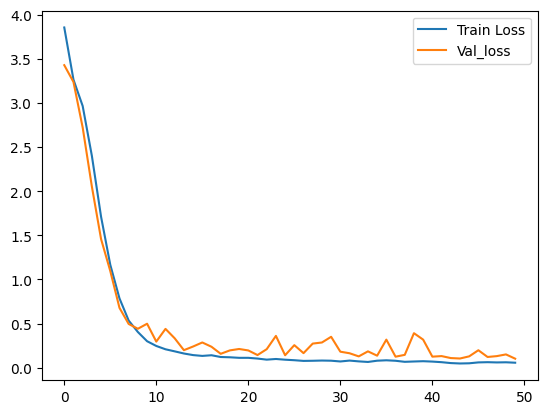

In [45]:
import matplotlib.pyplot as plt

plt.plot (range (50), train_CRNN.model_results_train["Loss"], label = 'Train Loss')
plt.plot(train_CRNN.model_results_val["Loss"],label='Val_loss')
plt.legend()
plt.show()

In [27]:
def Conf_matrix(model, dataloader, device , num_classes = 66):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():  # No gradients needed for validation
        for images, targets, input_lengths, target_lengths in dataloader:
            images, targets = images.to(device), targets.to(device)

            # Get model predictions
            logits = model(images)
            log_probs = logits.permute(1, 0, 2)  # (T, N, C)
            predictions = log_probs.argmax(2).transpose(0, 1).cpu().numpy()  # (batch_size, max_seq_len)

            # Decode predictions and targets
            pred_texts = ctc_decode(predictions, blank=0)  # Decode predictions
            target_texts = [targets[i][:target_lengths[i]].tolist() for i in range(len(targets))]

            # Debugging
            # print("Batch:")
            # print("Predictions (raw):", predictions)
            # print("Decoded Predictions:", pred_texts)
            # print("Targets (raw):", target_texts)

            # Align predictions and targets
            for pred, target in zip(pred_texts, target_texts):
                # print("Pred (aligned):  ", pred)
                # print("Target (aligned):", target)
                min_len = min(len(pred), len(target))  # Align lengths
                all_predictions.extend(pred[:min_len])  # Add aligned predictions
                all_targets.extend(target[:min_len])   # Add aligned targets

    # Compute confusion matrix
    labels = list(range(num_classes))  # Labels are [0, 1, 2, ..., num_classes-1]
    cf_matrix = confusion_matrix(all_targets, all_predictions, labels=labels)
    return cf_matrix


[[   0    0    0 ...    0    0    0]
 [   0   12    0 ...    0    1    0]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ... 1542    2    0]
 [   0    0    0 ...    6  368    0]
 [   0    0    0 ...    0    0    7]]


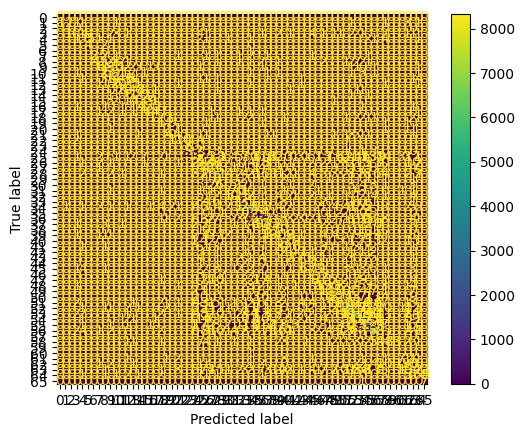

In [28]:
cm = Conf_matrix(model, val_data, device)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

/home/dornika/OCR_Project/OCR_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 1728 (\N{ARABIC LETTER HEH WITH YEH ABOVE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dornika/OCR_Project/OCR_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Matplotlib currently does not support Arabic natively.
  fig.canvas.print_figure(bytes_io, **kw)


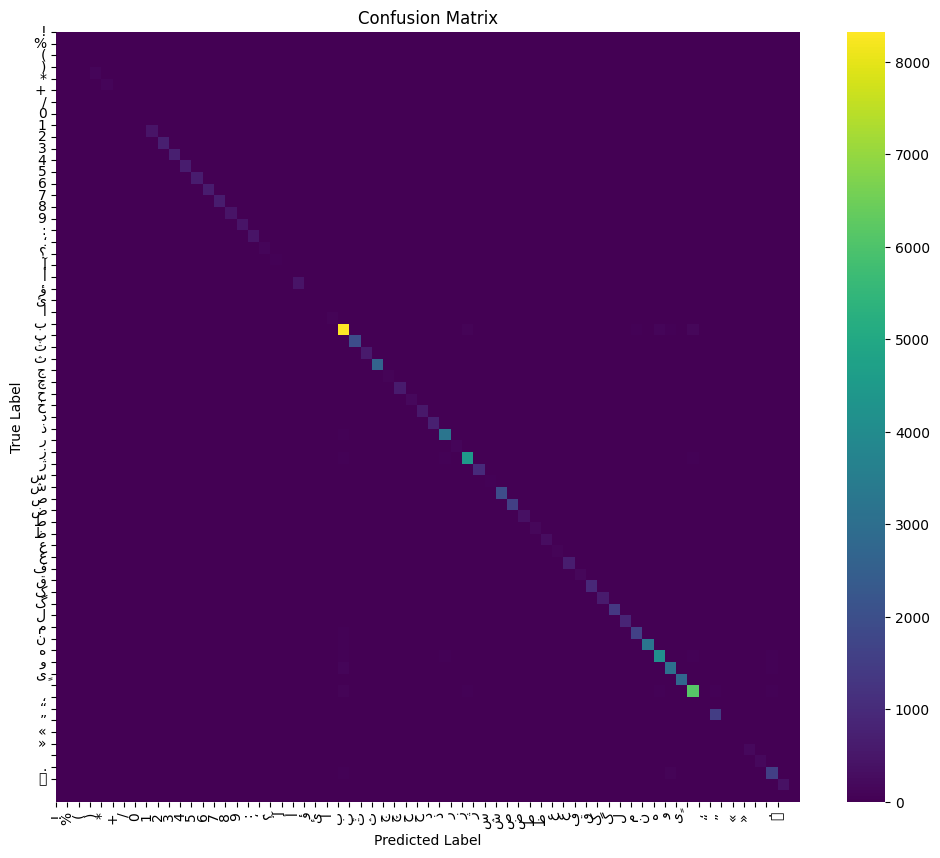

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cf_matrix, class_names):
    plt.figure(figsize=(12, 10))  # Increase the figure size for better readability
    sns.heatmap(cf_matrix, annot=False, fmt='g', cmap='viridis', cbar=True)

    # Set tick labels to be rotated and readable
    plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=90)
    plt.yticks(ticks=range(len(class_names)), labels=class_names, rotation=0)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage:
# class_names should be a list of labels, e.g., ['a', 'b', 'c', ...]
# cf_matrix is the confusion matrix array obtained from your function
# class_names = [str(i) for i in range(len(cf_matrix))]  # Generate class labels if not available
plot_confusion_matrix(cm, char_list)


In [69]:
def OCR(image , char_to_index):
  model.eval()
  transformed_image = train_transforms(image)
  model_input = transformed_image.unsqueeze(0)
  x = model_input.to(device)
  model_output = model(x)
  model_output = model_output.permute(1, 0, 2)
  predictions = model_output.argmax(2).transpose(0, 1).cpu().numpy()
  predictions = ctc_decode(predictions, blank=0)
  print(predictions)
  results = []
  for text in predictions:
    text_output = [list(char_to_index.keys())[list(char_to_index.values()).index(index)] for index in text ]
    results.append(text_output)
  return results


In [102]:
image = Image.open("/content/persian_unique_ocr_dataset/04558_156_35334.png").convert("RGB")

In [79]:
test = pd.read_csv("/content/test_df.csv")
test = test.loc[:, ~test.columns.str.contains('^Unnamed')]
test.head(10)

,index,label,page,top_left_y,bot_right_y,top_left_x,bot_right_x,path
0,518242,اغماض،,4964,520,550,45,103,04964_166_518242.png
1,648841,مرجعیت,5210,645,675,203,260,05210_164_648841.png
2,543131,تأثر،,4692,610,640,428,462,04692_131_543131.png
3,579292,همکاریشیما,5069,625,655,45,129,05069_183_579292.png
4,652706,داستان‌نویس،,5066,520,550,199,295,05066_145_652706.png
5,1015608,وفقط,4284,450,480,227,264,04284_139_1015608.png
6,35334,صحرایی,4558,610,640,348,408,04558_156_35334.png
7,141224,دریافت.,3445,380,410,452,512,03445_105_141224.png
8,39708,قطار,3051,135,165,190,222,03051_25_39708.png
9,37847,افشای,4444,330,360,525,575,04444_74_37847.png


In [103]:
result = OCR(image, char_to_index)[0]

[[41, 39, 32, 36, 25, 56, 56]]


In [83]:
# prompt: concat all chars in list of chars

def concat_chars(char_list):
  return "".join(char_list)

In [104]:
concat_chars(result)

'صسحرایی'

In [105]:
torch.save(model.state_dict(), "test1")

In [106]:
!cp /content/test1 /content/drive/MyDrive/ocr/test1

In [ ]:
# prompt: write function to use model output and decode it by f.nn.ctc_beam_search_decoder

import tensorflow as tf

def decode_ctc_output(model_output, input_length):
    decoded_output, log_probabilities = tf.nn.ctc_beam_search_decoder(
        model_output, input_length, beam_width=100
    )
    return decoded_output, log_probabilities

In [ ]:
model = CRNN()
logits = model(torch.randn([50,1,32,100]))
torch.save(model.state_dict(), "test")
print(logits.size())

torch.Size([50, 24, 66])


In [ ]:
model = CRNN()
model.load_state_dict(torch.load("test", weights_only=True))
model.eval()
logits = model(torch.randn([50,1,32,100]))
print(logits.size())

torch.Size([50, 24, 66])


In [29]:
os.makedirs("checkpoints", exist_ok=True)